In [ ]:
import pandas as pd
import numpy as np
import cv2    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from keras.optimizers import SGD

from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

plt.style.use('ggplot')

%matplotlib inline

In [4]:
import tensorflow as tf
print(tf.__version__)

1.2.0


In [16]:
# set variables 
main_folder = 'C:/BE_project/celeba-dataset/'
images_folder = main_folder + 'img_align_celeba/img_align_celeba/'

EXAMPLE_PIC = images_folder + '000506.jpg'

TRAINING_SAMPLES = 10000
VALIDATION_SAMPLES = 2000
TEST_SAMPLES = 2000
IMG_WIDTH = 178
IMG_HEIGHT = 218
BATCH_SIZE = 16
NUM_EPOCHS = 20

In [17]:
# import the data set that include the attribute for each picture
df_attr = pd.read_csv(main_folder + 'list_attr_celeba.csv')
df_attr.set_index('image_id', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
df_attr.shape

(202599, 40)

In [18]:
# List of available attributes
for i, j in enumerate(df_attr.columns):
    print(i, j)

0 5_o_Clock_Shadow
1 Arched_Eyebrows
2 Attractive
3 Bags_Under_Eyes
4 Bald
5 Bangs
6 Big_Lips
7 Big_Nose
8 Black_Hair
9 Blond_Hair
10 Blurry
11 Brown_Hair
12 Bushy_Eyebrows
13 Chubby
14 Double_Chin
15 Eyeglasses
16 Goatee
17 Gray_Hair
18 Heavy_Makeup
19 High_Cheekbones
20 Male
21 Mouth_Slightly_Open
22 Mustache
23 Narrow_Eyes
24 No_Beard
25 Oval_Face
26 Pale_Skin
27 Pointy_Nose
28 Receding_Hairline
29 Rosy_Cheeks
30 Sideburns
31 Smiling
32 Straight_Hair
33 Wavy_Hair
34 Wearing_Earrings
35 Wearing_Hat
36 Wearing_Lipstick
37 Wearing_Necklace
38 Wearing_Necktie
39 Young


Smiling    1
Male       0
Young      1
Name: 000506.jpg, dtype: int64

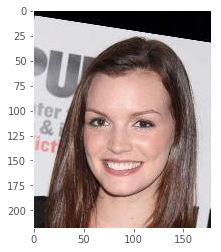

In [19]:
# plot picture and attributes
img = load_img(EXAMPLE_PIC)
plt.grid(False)
plt.imshow(img)
df_attr.loc[EXAMPLE_PIC.split('/')[-1]][['Smiling','Male','Young']] #some attributes

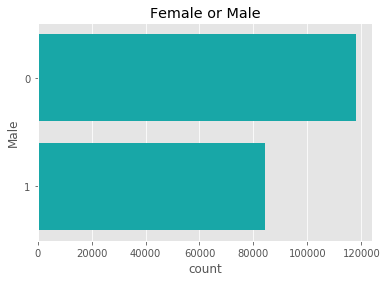

In [20]:
# Female or Male?
plt.title('Female or Male')
sns.countplot(y='Male', data=df_attr, color="c")
plt.show()

In [21]:
# Recomended partition
df_partition = pd.read_csv(main_folder + 'list_eval_partition.csv')
df_partition.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [22]:
# display counter by partition
# 0 -> TRAINING
# 1 -> VALIDATION
# 2 -> TEST
df_partition['partition'].value_counts().sort_index()

0    162770
1     19867
2     19962
Name: partition, dtype: int64

In [56]:
# join the partition with the attributes
df_partition.set_index('image_id', inplace=True)
df_par_attr = df_partition.join(df_attr['Male'], how='inner')
df_par_attr.head()

KeyError: 'image_id'

In [24]:
def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)

    return x


def generate_df(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    
    '''
    
    df_ = df_par_attr[(df_par_attr['partition'] == partition) 
                           & (df_par_attr[attr] == 0)].sample(int(num_samples/2))
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 1)].sample(int(num_samples/2))])

    # for Train and Validation
    if partition != 2:
        x_ = np.array([load_reshape_img(images_folder + fname) for fname in df_.index])
        x_ = x_.reshape(x_.shape[0], 218, 178, 3)
        y_ = np_utils.to_categorical(df_[attr],2)
    # for Test
    else:
        x_ = []
        y_ = []

        for index, target in df_.iterrows():
            im = cv2.imread(images_folder + index)
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis =0)
            x_.append(im)
            y_.append(target[attr])

    return x_, y_

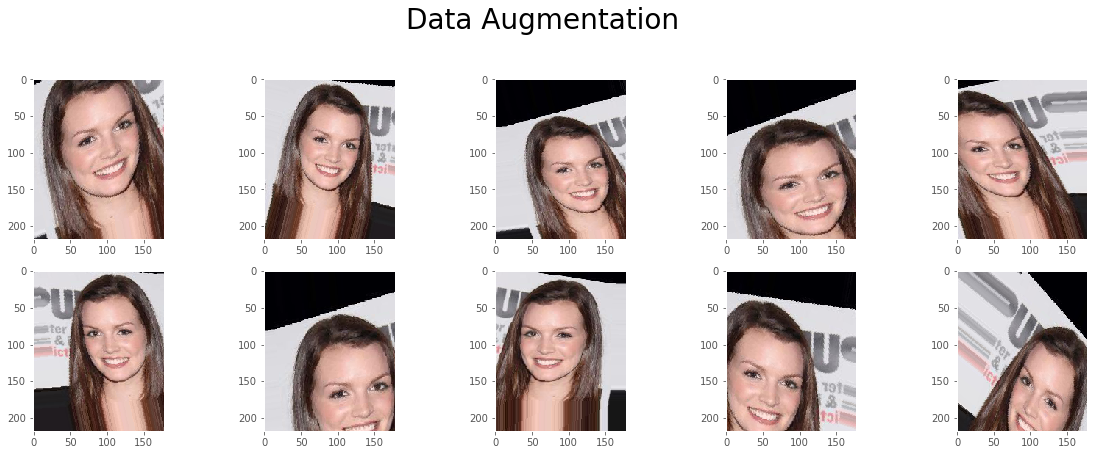

In [25]:
# Generate image generator for data augmentation
datagen =  ImageDataGenerator(
  #preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)

# load one image and reshape
img = load_img(EXAMPLE_PIC)
x = img_to_array(img)/255.
x = x.reshape((1,) + x.shape)

# plot 10 augmented images of the loaded iamge
plt.figure(figsize=(20,10))
plt.suptitle('Data Augmentation', fontsize=28)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3, 5, i+1)
    plt.grid(False)
    plt.imshow( batch.reshape(218, 178, 3))
    
    if i == 9:
        break
    i += 1
    
plt.show()

In [26]:
# Train data
x_train, y_train = generate_df(0, 'Male', TRAINING_SAMPLES)

# Train - Data Preparation - Data Augmentation with generators
train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(
x_train, y_train,
batch_size=BATCH_SIZE,
)

In [27]:
# Validation Data
x_valid, y_valid = generate_df(1, 'Male', VALIDATION_SAMPLES)

'''
# Validation - Data Preparation - Data Augmentation with generators
valid_datagen = ImageDataGenerator(
  preprocessing_function=preprocess_input,
)

valid_datagen.fit(x_valid)

validation_generator = valid_datagen.flow(
x_valid, y_valid,
)
'''

'\n# Validation - Data Preparation - Data Augmentation with generators\nvalid_datagen = ImageDataGenerator(\n  preprocessing_function=preprocess_input,\n)\n\nvalid_datagen.fit(x_valid)\n\nvalidation_generator = valid_datagen.flow(\nx_valid, y_valid,\n)\n'

In [58]:
# Import InceptionV3 Model
inc_model = InceptionV3(weights="imagenet",
                        include_top=False,
                        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

print("number of layers:", len(inc_model.layers))
#inc_model.summary()

KeyboardInterrupt: 

In [30]:
#Adding custom Layers
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(2,activation="softmax")(x)

In [31]:
# creating the final model 
model_ = Model(inputs=inc_model.input, outputs=predictions)

# Lock initial layers to do not be trained
for layer in model_.layers[:52]:
    layer.trainable = False

# compile the model
model_.compile(optimizer=SGD(lr=0.0001, momentum=0.9)
                    , loss='categorical_crossentropy'
                    , metrics=['accuracy'])

In [32]:
#https://keras.io/models/sequential/ fit generator
checkpointer = ModelCheckpoint(filepath='weights.best.inc.maleee.hdf5', 
                               verbose=1, save_best_only=True)

In [43]:
hist = model_.fit_generator(train_generator
                      , validation_data = (x_valid, y_valid)
                      , steps_per_epoch= TRAINING_SAMPLES/BATCH_SIZE
                      , epochs= 2
                      , callbacks=[checkpointer]
                      , verbose=1
                    )

Epoch 1/2
625/625 [==============================] - 8386s 13s/step - loss: 0.1358 - acc: 0.9508 - val_loss: 7.7894 - val_acc: 0.4580
Epoch 2/2
625/625 [==============================] - 8335s 13s/step - loss: 0.1284 - acc: 0.9515 - val_loss: 7.7645 - val_acc: 0.5070


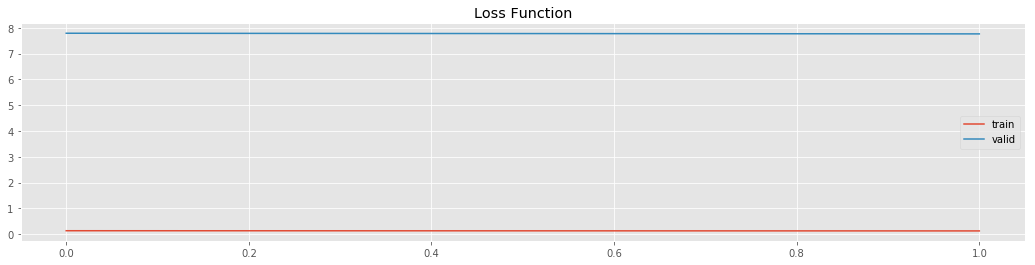

In [44]:
# Plot loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

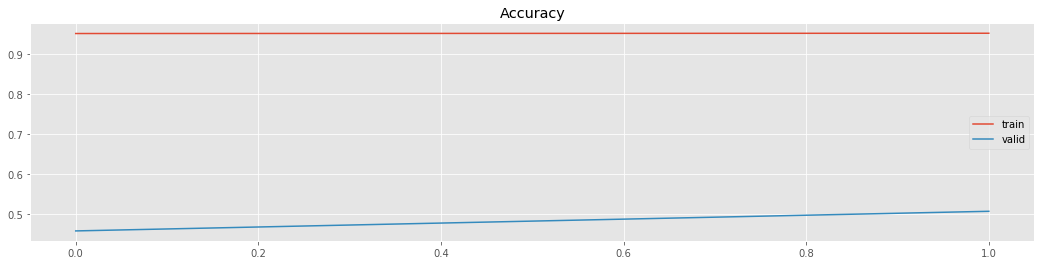

In [45]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['acc'], label = 'train')
plt.plot(hist.history['val_acc'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

In [47]:
#load the best model
model_.load_weights('weights.best.inc.maleee.hdf5')

In [48]:
# Test Data
x_test, y_test = generate_df(2, 'Male', TEST_SAMPLES)

# generate prediction
model_predictions = [np.argmax(model_.predict(feature)) for feature in x_test ]

# report test accuracy
test_accuracy = 100 * np.sum(np.array(model_predictions)==y_test) / len(model_predictions)
print('Model Evaluation')
print('Test accuracy: %.4f%%' % test_accuracy)
print('f1_score:', f1_score(y_test, model_predictions))

Model Evaluation
Test accuracy: 51.6000%
f1_score: 0.09869646182495344


In [49]:
#dictionary to name the prediction
gender_target = {0: 'Female'
                , 1: 'Male'}

def img_to_display(filename):
    # inspired on this kernel:
    # https://www.kaggle.com/stassl/displaying-inline-images-in-pandas-dataframe
    # credits to stassl :)
    
    i = Image.open(filename)
    i.thumbnail((200, 200), Image.LANCZOS)
    
    with BytesIO() as buffer:
        i.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()
    

def display_result(filename, prediction, target):
    '''
    Display the results in HTML
    
    '''

    gender = 'Male'
    gender_icon = "https://i.imgur.com/nxWan2u.png"
        
    if prediction[1] <= 0.5:
        gender_icon = "https://i.imgur.com/oAAb8rd.png"
        gender = 'Female'
            
    display_html = '''
    <div style="overflow: auto;  border: 2px solid #D8D8D8;
        padding: 5px; width: 420px;" >
        <img src="data:image/jpeg;base64,{}" style="float: left;" width="200" height="200">
        <div style="padding: 10px 0px 0px 20px; overflow: auto;">
            <img src="{}" style="float: left;" width="40" height="40">
            <h3 style="margin-left: 50px; margin-top: 2px;">{}</h3><br>
            <p style="margin-left: 50px; margin-top: -6px; font-size: 12px">{} prob.</p><br>
            <p style="margin-left: 50px; margin-top: -16px; font-size: 12px">Real Target: {}</p><br>
            <p style="margin-left: 50px; margin-top: -16px; font-size: 12px">Filename: {}</p><br>
        </div>
    </div>
    '''.format(img_to_display(filename)
               , gender_icon
               , gender
               , "{0:.2f}%".format(round(max(prediction)*100,2))
               , gender_target[target]
               , filename.split('/')[-1]
               )

    display(HTML(display_html))

In [50]:
#filename=images_folder + '000506.jpg'
def gender_prediction(filename):
    '''
    predict the gender
    
    input:
        filename: str of the file name
        
    return:
        array of the prob of the targets.'''''
    
    
    filename=images_folder + '000506.jpg'
    im = cv2.imread(filename)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (178, 218)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    
    # prediction
    result = model_.predict(im)
    prediction = np.argmax(result)
    
    return result
    


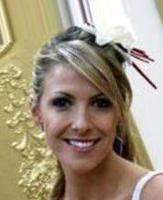


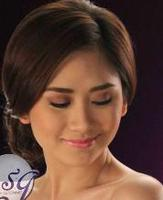


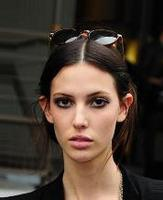


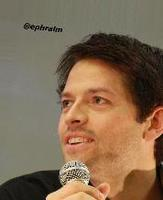


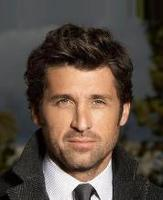


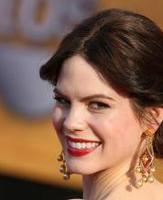


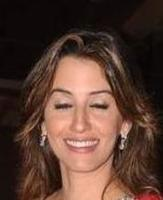


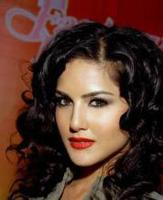

In [53]:
#select random images of the test partition
df_to_test = df_par_attr[(df_par_attr['partition'] == 2)].sample(8)

for index, target in df_to_test.iterrows():
    result = gender_prediction(images_folder + index)
    
    #display result
    display_result(images_folder + index, result[0], target['Male'])